> # Trading Strategies using Machine Learning
---

### Built ML models on the features prepared, and Compared performace
---

- Propose and train 3-6 models by feeding in the features prepared,  Compare the model performance using RMSE between the fitted Y and actual Y in testing period.  

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as ss
import statsmodels.api as sm
from fredapi import Fred
from functools import reduce
from pandas_datareader import DataReader
import warnings
import yfinance as yf
from scipy.optimize import minimize
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn import linear_model
import xgboost
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

/Users/rahulodedra/anaconda3/lib/python3.11/site-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [2]:
df=pd.read_csv('feature_mart.csv',index_col=0)
df.head()

,Shanghai comp,BSE,Bovespa,HangSeng,Kospi,Nikkei225,Adj Close,Volume,Mkt-RF,SMB,...,AMERIBOR,T10YIE_y,T5YIE,BAMLH0A0HYM2,BAMLH0A0HYM2EY,DGS10,DGS1,RIFSPPFAAD90NB,DCOILWTICO,DHHNGSP
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-04,3385.709961,33969.640625,78647.0,30736.480469,2466.459961,23506.330078,20.974667,149194500,0.42,-0.22,...,1.55779,2.01,1.92,3.40,5.67,2.46,1.82,1.65,61.98,4.65
2018-01-09,3413.899902,34443.191406,78864.0,31011.410156,2510.229980,23849.990234,22.246000,107199000,0.15,-0.39,...,1.55600,2.03,1.95,3.33,5.66,2.55,1.78,1.64,62.92,2.93
2018-01-10,3421.833984,34433.070312,78201.0,31073.720703,2499.750000,23788.199219,22.320000,64648500,-0.07,0.14,...,1.55585,2.03,1.94,3.42,5.75,2.55,1.78,1.57,63.60,3.16
2018-01-11,3425.344971,34503.488281,79365.0,31120.390625,2487.909912,23710.429688,22.530001,99682500,0.87,1.13,...,1.55484,2.00,1.89,3.40,5.72,2.54,1.77,1.58,63.81,3.16
2018-01-12,3428.940918,34592.390625,79349.0,31412.539062,2496.419922,23653.820312,22.414667,72376500,0.66,-0.33,...,1.55643,2.01,1.92,3.37,5.72,2.55,1.78,1.65,64.22,4.06


> ### Model building
---

### Linear Regression

In [3]:
X=df.drop('Adj Close',axis=1)
y=df['Adj Close']
# y=np.diff(np.log(df['Adj Close'].values))
# y=np.append(y[0],y)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# Linear Regression
linear_model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
y_pred = linear_model.predict(sm.add_constant(X_test))
lr_rmse = mean_squared_error(y_test,y_pred,squared=False)
linear_r_squared = linear_model.rsquared
linear_adj_r_squared = linear_model.rsquared_adj

print("\nLinear Regression Model Summary:")
print("\nRMSE:",lr_rmse)
print("R-squared:", linear_r_squared)
print("Adjusted R-squared:", linear_adj_r_squared)


Linear Regression Model Summary:

RMSE: 20.183321228267076
R-squared: 0.9702744598398155
Adjusted R-squared: 0.9688070495357162


### Random Forest 

In [4]:
X=df.drop('Adj Close',axis=1)
y=df['Adj Close']
# y=np.diff(np.log(df['Adj Close'].values))
# y=np.append(y[0],y)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

rf=RandomForestRegressor(n_estimators=100,
                           criterion='squared_error',
                           max_depth=3,
                           min_samples_split=2,
                           bootstrap=True,
                           random_state=42)
rf.fit(X_train,y_train)
y_pred=rf.predict(X_test)

rf_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
rf_r2_score = r2_score(y_test, y_pred)
n = X_train.shape[0]
p = X_train.shape[1]
rf_adj_r2_score = 1-(1-rf_r2_score)*((n-1)/(n-p-1))

print("\nRandom Forest Model Summary:")
print("\nRMSE:",rf_rmse)
print("R-squared:", rf_r2_score)
print("Adjusted R-squared:", rf_adj_r2_score)


Random Forest Model Summary:

RMSE: 20.35505002524641
R-squared: 0.9687389167009177
Adjusted R-squared: 0.9671493700924898


### XGBoost 

In [5]:
X=df.drop('Adj Close',axis=1)
y=df['Adj Close']
# y=np.diff(np.log(df['Adj Close'].values))
# y=np.append(y[0],y)

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

xgb = xgboost.XGBRegressor(booster='gbtree',objective='reg:squarederror')
param_grid = {'learning_rate':[0.01,0.05,0.1],
              'max_depth': [2,4,6],
              'n_estimators': [20,50,100,200]}

xgb_model = GridSearchCV(estimator=xgb, param_grid=param_grid,cv=5)
xgb_model.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster='gbtree',
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=No...,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 4, 6],
                         'n_estimators': [20, 50, 100, 200]})

In [6]:
print(xgb_model.best_score_)
xg_params=xgb_model.best_params_
print('Best Params: ',xg_params)

0.9902469786025441
Best Params:  {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}


In [7]:
top_param_model = xgb_model.best_estimator_

In [8]:
y_pred = top_param_model.predict(X_test)
xg_rmse = np.sqrt(mean_squared_error(y_test,y_pred))
xgb_r2_score = r2_score(y_test, y_pred)
n = X_train.shape[0]
p = X_train.shape[1]
xgb_adj_r2_score = 1-(1-xgb_r2_score)*((n-1)/(n-p-1))

print("\nXGBoost Model Summary:")
print("\nRMSE:",xg_rmse)
print("R-squared:", xgb_r2_score)
print("Adjusted R-squared:", xgb_adj_r2_score)


XGBoost Model Summary:

RMSE: 9.068397221446896
R-squared: 0.9937953006007614
Adjusted R-squared: 0.9934798074109695


### SARIMAX

In [9]:
start_date = '2018-01-01'
end_date = '2023-12-31'
ticker = 'TSLA' 

def get_stock_data(ticker,start_date=start_date,end_date=end_date):
    data = yf.download(ticker,start_date,end_date)
    return data['Adj Close']

# get historical price
price_data = get_stock_data(ticker,start_date,end_date)
df=pd.DataFrame(price_data)

[*********************100%%**********************]  1 of 1 completed


In [10]:
df=df['Adj Close'].resample('M').mean().reset_index()
df=df.set_index('Date')

In [11]:
df.shape

(72, 1)

In [12]:
SARIMA_model = SARIMAX(df['Adj Close'],order = (1,1,1),seasonal_order = (1,1,1,12))
result = SARIMA_model.fit(disp=0)
# reults
print(result.summary())

/Users/rahulodedra/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)
/Users/rahulodedra/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                          Adj Close   No. Observations:                   72
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -287.594
Date:                            Fri, 03 May 2024   AIC                            585.189
Time:                                    13:57:07   BIC                            595.577
Sample:                                01-31-2018   HQIC                           589.244
                                     - 12-31-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6149      0.144     -4.265      0.000      -0.897      -0.332
ma.L1          0.9999     70.063   

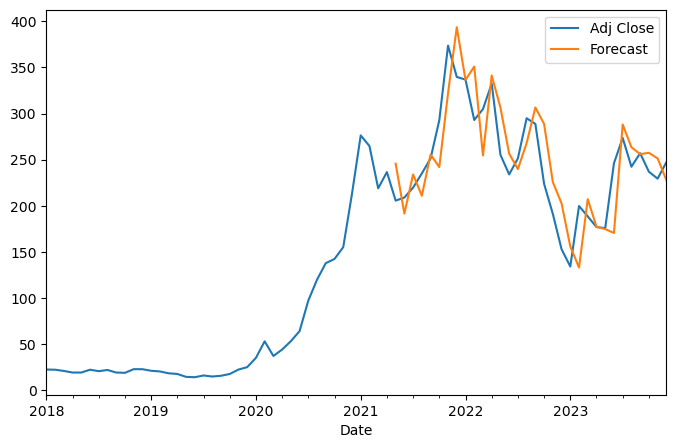

In [13]:
predicted = result.predict(start=40, end=72)
df["Forecast"] = result.predict(start=40, end=72)
df[["Adj Close","Forecast"]].plot(figsize = (8,5));

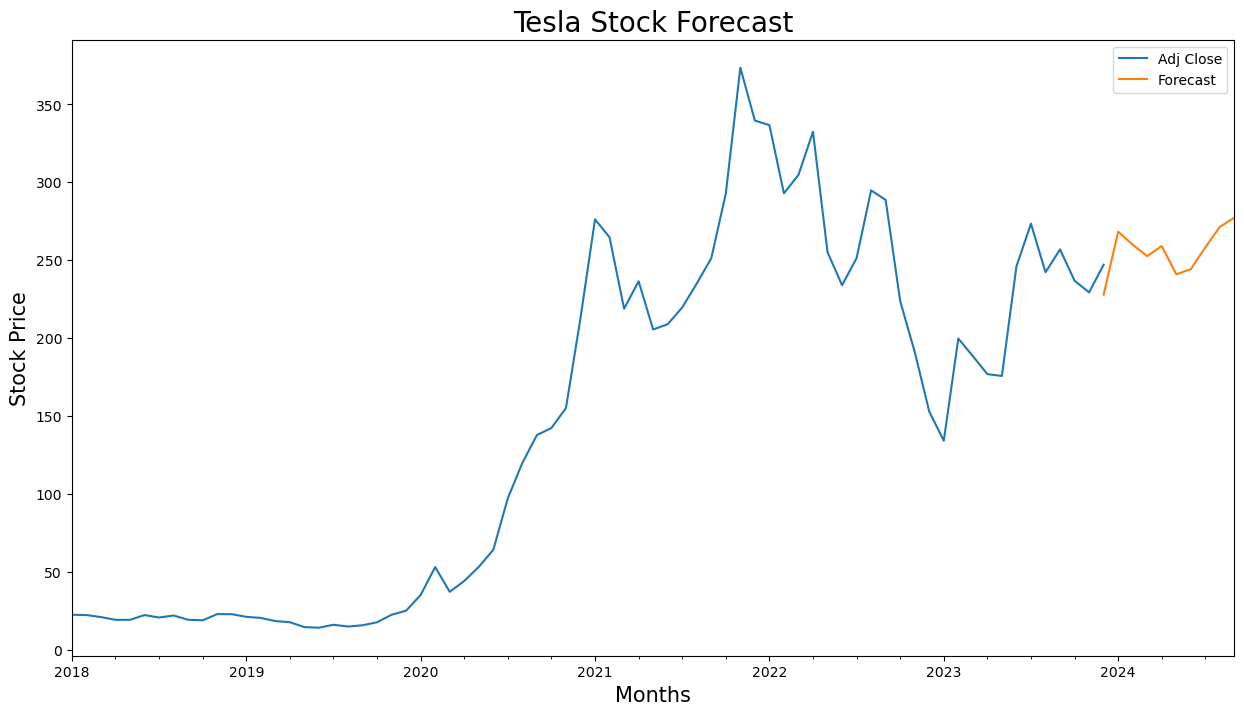

In [14]:
from pandas.tseries.offsets import DateOffset

future_dates = [df.index[-1] + DateOffset(months = x) for x in range(1,10)]
future_data = pd.DataFrame(index=future_dates,columns=df.columns)

final_data=pd.concat([df,future_data])
final_data.head()

# forecasting
final_data["Forecast"]=result.predict(start=71,end=90)

final_data["Adj Close"].plot()
final_data["Forecast"].plot(figsize = (15,8))
plt.title("Tesla Stock Forecast",size = 20)
plt.xlabel("Months",size=15)
plt.ylabel("Stock Price",size=15)
plt.legend();

In [15]:
actual = df['Adj Close'][40:]
predicted = predicted[:-1]
sarimax_rmse = np.sqrt(mean_squared_error(actual,predicted))
print('RMSE of SARIMA model:',round(sarimax_rmse,2))

RMSE of SARIMA model: 36.17


## RMSE Comparisons of Different Models

In [16]:
rmse = {'Linear Regression':lr_rmse,
        'Random Forest':rf_rmse,
        'XGBoost':xg_rmse,
        'Sarimax':sarimax_rmse}

model_rmse = pd.DataFrame.from_dict(rmse,orient='index')
model_rmse.index.name='Model'
model_rmse.rename(columns={model_rmse.columns[0]:'RMSE ($)'})

,RMSE
Model,
Linear Regression,20.183321
Random Forest,20.355050
XGBoost,9.068397
Sarimax,36.174437


## 